In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
import corner
import astroquery
import sklearn as skl
import seaborn as sns
import scipy
import statsmodels.api as sm

from skimage import data
from skimage.feature import match_template
from scipy.signal import find_peaks
import math
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Simulate Point Sources

In [2]:
np.random.seed(27)

In [3]:
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')


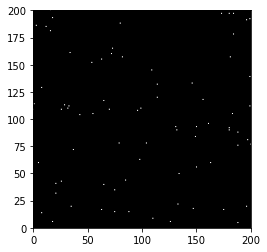

In [4]:
image = np.zeros((500, 500))
simpleRandomPoints = np.array([np.random.rand(500)*500,np.random.rand(500)*500]).T
for point in simpleRandomPoints:
    image[int(point[0]), int(point[1])] = 100

plt.imshow(image,vmin=0,vmax=100,cmap='gray', origin='lower')
plt.xlim(0,200)
plt.ylim(0,200)
plt.show()

In [5]:
from scipy.stats import rv_continuous
class flux_distr(rv_continuous):
    "Gaussian distribution"
    def _cdf(self, x):
        return x**(-3/2)
    def _rvs(self, size):
        uniformSamples = np.random.rand(size)
        return uniformSamples**(-2/3)
    def _pdf(self, x):
        return x**(-5/2)
    def _wrongpdf(self, x):
        return x**(-3/2)
    def _wrongrvs(self, size):
        uniformSamples = np.random.rand(size)
        return uniformSamples**(-2)
flux_distribution = flux_distr(name='flux_distribution')

In [6]:
simpleRandomPoints
df = pd.DataFrame(simpleRandomPoints.astype(int), columns=['x', 'y'])
df['color'] = np.random.normal(loc=2,scale=0.5,size=len(df))
df['f1'] = flux_distribution._rvs(size=len(df))
df['log_f1'] = np.log(df['f1'])
df['f2'] = df['f1']*np.exp(df['color'])
df['log_f2'] = np.log(df['f2'])
print(df)

       x    y     color        f1    log_f1         f2    log_f2
0    212  414  2.059285  1.228087  0.205458   9.628643  2.264742
1    407  345  2.791439  2.069449  0.727282  33.741267  3.518722
2    367  119  1.977362  1.929457  0.657238  13.937747  2.634601
3    434  266  1.568994  1.154375  0.143559   5.543094  1.712553
4    191  196  2.418902  4.299606  1.458523  48.299720  3.877426
..   ...  ...       ...       ...       ...        ...       ...
495  428  260  1.701282  1.333322  0.287674   7.307897  1.988955
496  215  384  1.323026  1.458928  0.377702   5.477930  1.700727
497  323  441  1.785642  1.062717  0.060829   6.337415  1.846471
498   15   75  1.806623  1.017951  0.017792   6.199166  1.824415
499  256  195  1.698525  1.008033  0.008001   5.509787  1.706526

[500 rows x 7 columns]


every source is a poisson experiment, so we take some 


for each pixel we have p_ij with some mean mu_ij 
so we do poisson(mu_ij) to get the actual image

we get mu_ij from sum over n sources and do mu_ij from k'th source plus the isotropic source 

mean number of photons for every pixel that comes from the k'th source and we get that from the psf of each source 


draw f1 from the power law and then use c to get f2

so total flux is f1 but you can plot f2 and c and f1

c physically is the powerlaw index of ln(E) vs ln(f(E))

2500 is a reasonable first amount of sources because it's some integral of dN/dF for f above some f_min, but as we change f_min that changes as well

this number ultimately dictates how crowded your image is

# Simulate Images based on point sources

In [7]:
def gaussian_psf(flux, xcenter, ycenter, size, fwhm=2.5):
    """
    Generates a 2D Gaussian PSF.

    Args:
        size (int): The size of the PSF array.
        fwhm (float): The full width at half maximum of the Gaussian.

    Returns:
        numpy.ndarray: A 2D Gaussian PSF.
    """
    
    x, y = np.indices((size, size))
    
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    gaussian = flux*np.exp(-((x - xcenter)**2 + (y - ycenter)**2) / (2 * sigma**2))
    
    return gaussian 

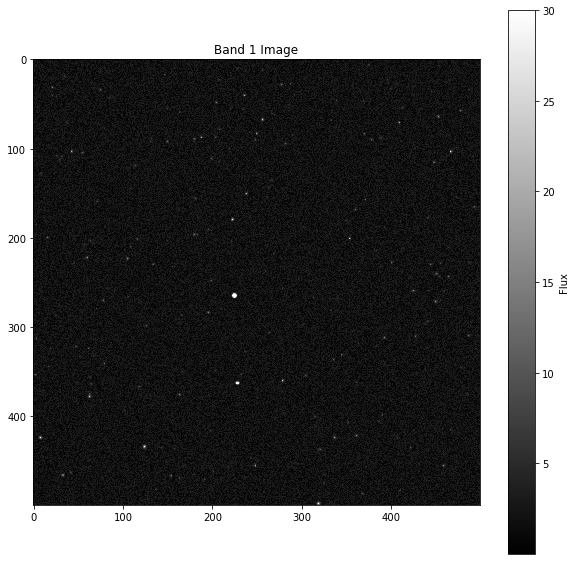

In [8]:
fig,ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
f1image = np.zeros((500, 500))
f1imageSignal = np.zeros((500, 500))
f1imageNoise = np.zeros((500, 500))


for index, row in df.iterrows():
    f1image[int(row['x']),int(row['y'])] = np.random.poisson(row['f1'], size=1)
    f1image += gaussian_psf(f1image[int(row['x']),int(row['y'])],int(row['x']), int(row['y']), size=500, fwhm=2.5)
f1imageSignal = f1image

noiseLevel = math.ceil(75*np.sum(f1image[~np.isnan(image)])/(500*500))
f1imageNoise = np.random.uniform(0, noiseLevel,size=250000)
f1imageNoise = f1imageNoise.reshape((500, 500))
f1image += f1imageNoise


plt.imshow(f1image, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Band 1 Image")
plt.show()

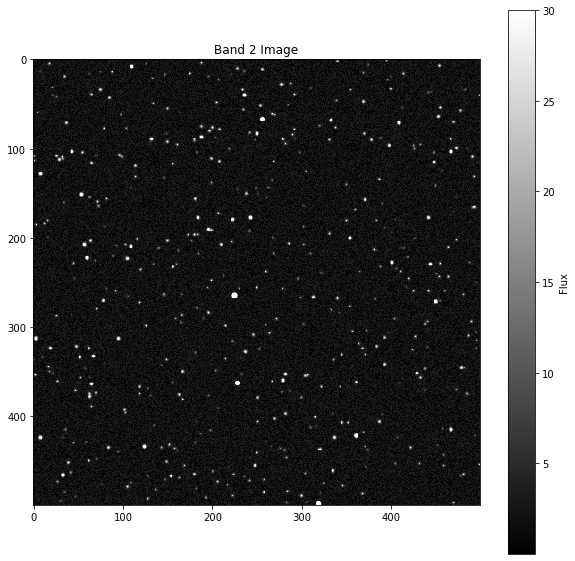

In [9]:
fig,ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
f2image = np.zeros((500, 500))
f2imageSignal = np.zeros((500, 500))
f2imageNoise = np.zeros((500, 500))


for index, row in df.iterrows():
    f2image[int(row['x']),int(row['y'])] = np.random.poisson(row['f2'], size=1)
    f2image += gaussian_psf(f2image[int(row['x']),int(row['y'])],int(row['x']), int(row['y']), size=500, fwhm=2.5)
f2imageSignal = f2image

#assume that noise is uniform between each band so we can use the same noise level
f2imageNoise = np.random.uniform(0, noiseLevel,size=250000)
f2imageNoise = f2imageNoise.reshape((500, 500))
f2image += f2imageNoise


plt.imshow(f2image, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Band 2 Image")
plt.show()

In [10]:
startX = int(np.random.uniform(0,400))
startY = int(np.random.uniform(0,400))

In [11]:
subf1Image = f1image.copy()
subf1Image = subf1Image[startX:startX+60, startY:startY+60]
subf2Image = f2image.copy()
subf2Image = subf2Image[startX:startX+60, startY:startY+60]

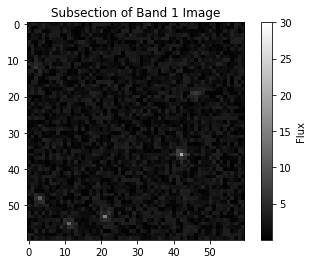

In [12]:
plt.imshow(subf1Image, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Subsection of Band 1 Image")
plt.show()

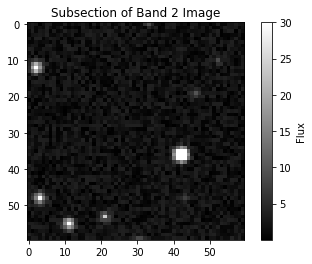

In [13]:
plt.imshow(subf2Image, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Subsection of Band 2 Image")
plt.show()

In [14]:
for index, row in df.iterrows():
    if startX <= row['x'] < startX + 60 and startY <= row['y'] < startY + 60:
        df.loc[(df['x'] == row['x']) & (df['y'] == row['y']), 'in_subsection'] = True
    else:
        df.loc[(df['x'] == row['x']) & (df['y'] == row['y']), 'in_subsection'] = False
df = df[df['in_subsection'] == True]
df['adjusted_x'] = df['x'] - startX
df['adjusted_y'] = df['y'] - startY

df

x    y     color        f1    log_f1          f2    log_f2  \
19   84  410  1.400503  1.646813  0.498842    6.681516  1.899345   
42   46  419  1.312972  1.325778  0.281999    4.928188  1.594971   
118  55  413  1.156184  1.740804  0.554347    5.531901  1.710531   
134  48  369  3.066131  1.123192  0.116175   24.102257  3.182305   
393  72  409  2.831829  5.974624  1.787521  101.428066  4.619350   
458  84  370  1.726746  4.103351  1.411804   23.070397  3.138550   
480  89  388  1.570163  2.473876  0.905786   11.892988  2.475949   
482  91  378  2.106968  3.181281  1.157284   26.160534  3.264252   

    in_subsection  adjusted_x  adjusted_y  
19           True          48          43  
42           True          10          52  
118          True          19          46  
134          True          12           2  
393          True          36          42  
458          True          48           3  
480          True          53          21  
482          True          55          11

In [15]:
TruePositive = []
TruePositiveDF = pd.DataFrame(columns=['x', 'y', 'f1', 'color','adjusted_x', 'adjusted_y'])
for index, row in df.iterrows():
    if f1imageSignal[int(row['x']),int(row['y'])]/f1imageNoise[int(row['x']),int(row['y'])] > 5 or f1imageSignal[int(row['x']),int(row['y'])]/f2imageNoise[int(row['x']),int(row['y'])] > 5:
        TruePositive.append([row['x'], row['y'], row['f1'], row['color'],row['adjusted_x'], row['adjusted_y']])
        TruePositiveDF = TruePositiveDF.append({'x': row['x'], 'y': row['y'], 'f1': row['f1'], 'color': row['color'],'adjusted_x': row['adjusted_x'],'adjusted_y': row['adjusted_y']}, ignore_index=True)
print(len(TruePositive))

7


# Point Source Finding

In [364]:
def getCenteredCandidatePositions(candidatePositions):
    trueCandidates = []
    candidatePositions = np.array(candidatePositions)
    for candidate in candidatePositions:
        #closePoints = []
        closePoints = candidatePositions[np.sqrt((candidate[0]-candidatePositions[:,0])**2+(candidate[1]-candidatePositions[:,1])**2)<=2]
        if len(closePoints)==0:
            trueCandidates.append(candidate)
            continue
        avgX = int(np.median(closePoints[:,0]))
        avgY = int(np.median(closePoints[:,1]))
        if np.array([avgX,avgY]) in np.array(trueCandidates):
            continue
        trueCandidates.append(np.array([avgX,avgY]))
        #print(np.array([avgX,avgY]))
    return trueCandidates

## Template Matching

In [23]:
def templateMatch(threshold,maxFlux1=100,maxFlux2=200):  
    #make it so that the template is a proper size for the flux and is centered
    i = 0
    for exFlux in range(5, maxFlux1):
        exPointSource = gaussian_psf(exFlux,5,5,11,fwhm=2.5)

        result = match_template(subf1Image, exPointSource,pad_input=True)
        resultIndices = np.argwhere(result >= threshold)
        if(i==0):
            candidatePositions = resultIndices
        else:
            candidatePositions = np.append(candidatePositions, resultIndices,axis=0)

        #since we know that maxFlux1 is larger than maxFlux2, we can just use the same template for the smaller fluxes
        result = match_template(subf2Image, exPointSource,pad_input=True)
        resultIndices = np.argwhere(result >= threshold)
        
        candidatePositions = np.append(candidatePositions, resultIndices,axis=0)
        i += 1

    for exFlux in range(maxFlux1+1, maxFlux2):  
        exPointSource = exFlux*gaussian_psf(exFlux,10,10,21,fwhm=2.5)
        result = match_template(subf2Image, exPointSource,pad_input=True)
        resultIndices = np.argwhere(result >= threshold)
        
        candidatePositions = np.append(candidatePositions, resultIndices,axis=0)
        i += 1

    candidatePositions = np.unique(candidatePositions, axis=0)
    return candidatePositions


/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


13


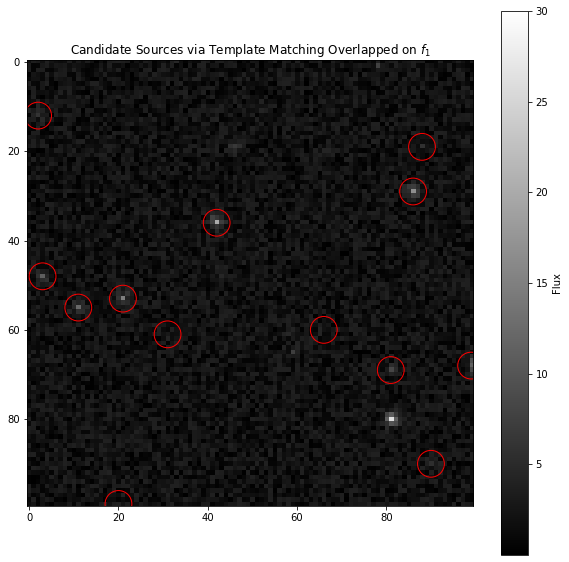

In [36]:
fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(getCenteredCandidatePositions(templateMatch(0.73,100,500)))
print(len(candidateSources))
candidateSources = np.flip(candidateSources,axis=1)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    ax.add_artist(plt.Circle((candidate[0], candidate[1]), 3, color='red', fill=False))
plt.imshow(subf1Image,vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Template Matching Overlapped on $f_1$")
plt.show()

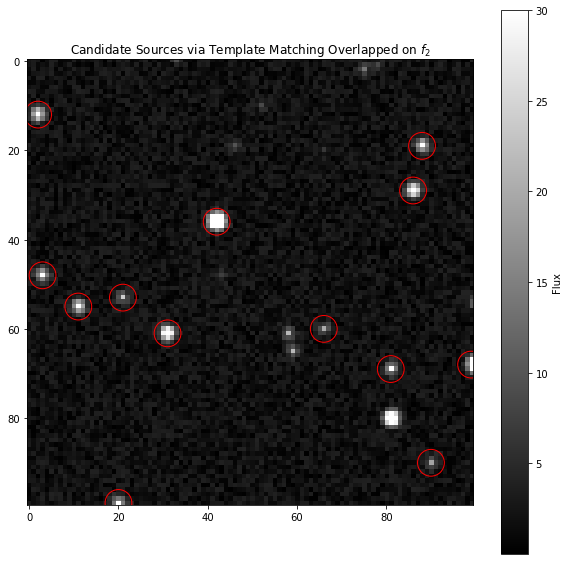

In [37]:
fig,ax = plt.subplots(figsize=(10, 10))
for candidate in candidateSources:
    ax.add_artist(plt.Circle((candidate[0], candidate[1]), 3, color='red', fill=False))
plt.imshow(subf2Image,vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Template Matching Overlapped on $f_2$")
plt.show()

# WLS

In [112]:
trueCandidates = getCenteredCandidatePositions(templateMatch(0.73,100,500))
designMatrix = np.zeros((2*100*100,2*len(trueCandidates)+1))

for j in range(0,len(trueCandidates)):
    psfImage = gaussian_psf(1,int(trueCandidates[j][0]), int(trueCandidates[j][1]), size=100, fwhm=2.5)
    psfImage = psfImage.reshape(100*100, order='F')
    designMatrix[:10000,j] = psfImage
    designMatrix[10000:,len(trueCandidates)+j] = psfImage

#include a constant term for the background flux
designMatrix[:,2*len(trueCandidates)] = np.random.rand(100*100*2)
imageMatrix = np.append(subf1Image.reshape(100*100, order='F'),subf2Image.reshape(100*100, order='F'),axis=0)

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


In [113]:
#we take the weights to be the inverse of the variance of the flux measurement for each pixel 
#because we model it as a poisson process we can say that the variance is equal to the flux (which is taken to be the mean hit count for a given obs. period)
weights = np.zeros(2*100*100)
for i in range(0,100):
    for j in range(0,100):
        weights[i+100*j] = 1/f1image[i,j]
        weights[i+100*j+10000] = 1/f2image[i,j]
        
weights = np.array(weights)

mod_wls = sm.WLS(imageMatrix, designMatrix, weights=weights)
res_wls = mod_wls.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.598
Model:                            WLS   Adj. R-squared (uncentered):              0.598
Method:                 Least Squares   F-statistic:                              1101.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):                        0.00
Time:                        10:57:35   Log-Likelihood:                         -53634.
No. Observations:               20000   AIC:                                  1.073e+05
Df Residuals:                   19973   BIC:                                  1.075e+05
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [114]:
trueCandidates = np.array(trueCandidates)
finalSources = np.array([trueCandidates[:,0],trueCandidates[:,1]]).T

proposedSources = pd.DataFrame(finalSources, columns=['x', 'y'])
#you have to adjust the x and y coordinates of the proposed sources to account for the subsection we took
proposedSources['x'] += startX
proposedSources['y'] += startY
proposedSources['f1'] = res_wls.params[:len(trueCandidates)]
proposedSources['f2'] = res_wls.params[len(trueCandidates):2*len(trueCandidates)]
proposedSources['log_f1'] = np.log(proposedSources['f1'])
proposedSources['log_f2'] = np.log(proposedSources['f2'])
proposedSources['color'] = np.log(proposedSources['f2']/proposedSources['f1'])
backgroundFlux = res_wls.params[-1]
print(proposedSources)

      x    y         f1          f2    log_f1    log_f2     color
0    48  369   5.131321   37.935316  1.635363  3.635883  2.000519
1    55  455   2.968567   26.047924  1.088079  3.259938  2.171859
2    65  453   8.823578   41.209215  2.177428  3.718662  1.541234
3    72  409  12.771001  120.449643  2.547177  4.791232  2.244055
4    84  370   6.400839   27.134769  1.856429  3.300816  1.444387
5    89  388   6.008987   13.871739  1.793256  2.629854  0.836597
6    91  378   7.200699   32.712169  1.974178  3.487747  1.513569
7    96  433   1.494331   13.990883  0.401679  2.638406  2.236727
8    97  398  -0.681873   52.565488       NaN  3.962060       NaN
9   104  466   9.739106   42.975742  2.276149  3.760636  1.484486
10  105  448   2.275776   21.647835  0.822321  3.074905  2.252584
11  126  457   3.537619   14.601529  1.263454  2.681126  1.417672
12  135  387  -0.860177   26.576274       NaN  3.280019       NaN


/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


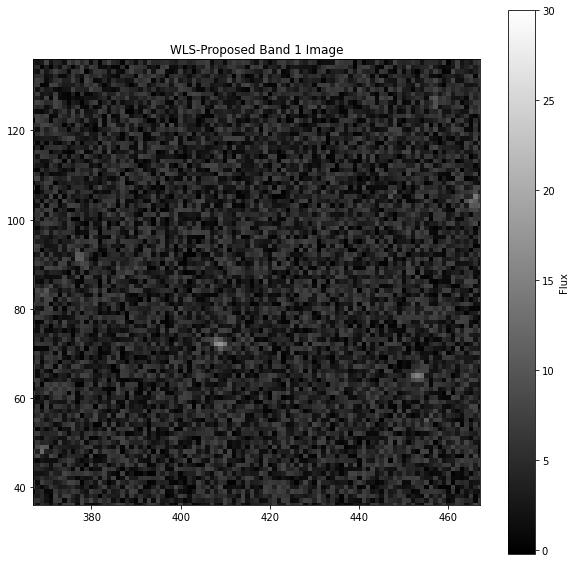

In [115]:
fig,ax = plt.subplots(figsize=(10, 10))
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
wlsimage = np.zeros((500, 500))


for index, row in proposedSources.iterrows():
    wlsimage += gaussian_psf(row['f1'],int(row['x']), int(row['y']), size=500, fwhm=2.5)

randomNoise = np.random.uniform(0, 2*math.ceil(backgroundFlux),size=250000)
randomNoise = randomNoise.reshape((500, 500))

wlsimage += randomNoise

#the x and y get flipped when we look at our imshow image
plt.ylim(startX, startX+100)
plt.xlim(startY, startY+100)
plt.imshow(wlsimage, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("WLS-Proposed Band 1 Image")
plt.show()

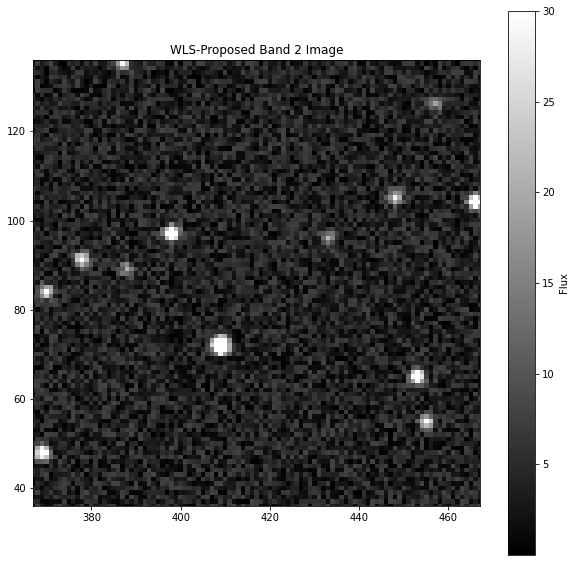

In [116]:
fig,ax = plt.subplots(figsize=(10, 10))
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
wlsimage = np.zeros((500, 500))


for index, row in proposedSources.iterrows():
    wlsimage += gaussian_psf(row['f2'],int(row['x']), int(row['y']), size=500, fwhm=2.5)

randomNoise = np.random.uniform(0, 2*math.ceil(backgroundFlux),size=250000)
randomNoise = randomNoise.reshape((500, 500))

wlsimage += randomNoise

#the x and y get flipped when we look at our imshow image
plt.ylim(startX, startX+100)
plt.xlim(startY, startY+100)
plt.imshow(wlsimage, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("WLS-Proposed Band 2 Image")
plt.show()

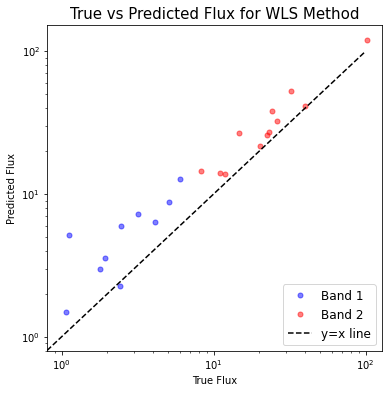

In [117]:
fig,ax = plt.subplots(figsize=(6,6))
trueVpredictedf1 = []
trueVpredictedf2 = []
sourceFound = np.zeros(df.shape[0])
for i in range(len(proposedSources)):
        proposedX = proposedSources['x'].iloc[i]
        proposedY = proposedSources['y'].iloc[i]
        
        matchFound = False
        for j in range(len(df)):
            trueX = df['x'].iloc[j]
            trueY = df['y'].iloc[j]
            if (proposedX == trueX and proposedY == trueY):
                sourceFound[j] = 1
                matchFound = True
                trueVpredictedf1.append([df['f1'].iloc[j],proposedSources['f1'].iloc[i]])
                trueVpredictedf2.append([df['f2'].iloc[j],proposedSources['f2'].iloc[i]])
                break
        if(not matchFound):
            trueVpredictedf1.append([0,proposedSources['f1'].iloc[i]])
            trueVpredictedf2.append([0,proposedSources['f2'].iloc[i]])

for j in range(len(df)):
        if(sourceFound[j]!=1):
            trueVpredictedf1.append([df['f1'].iloc[j],0])
            trueVpredictedf2.append([df['f2'].iloc[j],0])

trueVpredictedf1 = np.array(trueVpredictedf1)
trueVpredictedf2 = np.array(trueVpredictedf2)

plt.plot(trueVpredictedf1[:,0], trueVpredictedf1[:,1], 'o', markersize=5, color='blue', alpha=0.5, label='Band 1')
plt.plot(trueVpredictedf2[:,0], trueVpredictedf2[:,1], 'o', markersize=5, color='red', alpha=0.5, label='Band 2')
plt.plot(np.linspace(0, 100,100), np.linspace(0, 100,100), color='black', linestyle='--', label='y=x line')
plt.xlabel('True Flux')
plt.ylabel('Predicted Flux')
plt.legend(fontsize=12,loc='lower right')
plt.title('True vs Predicted Flux for WLS Method',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.show()

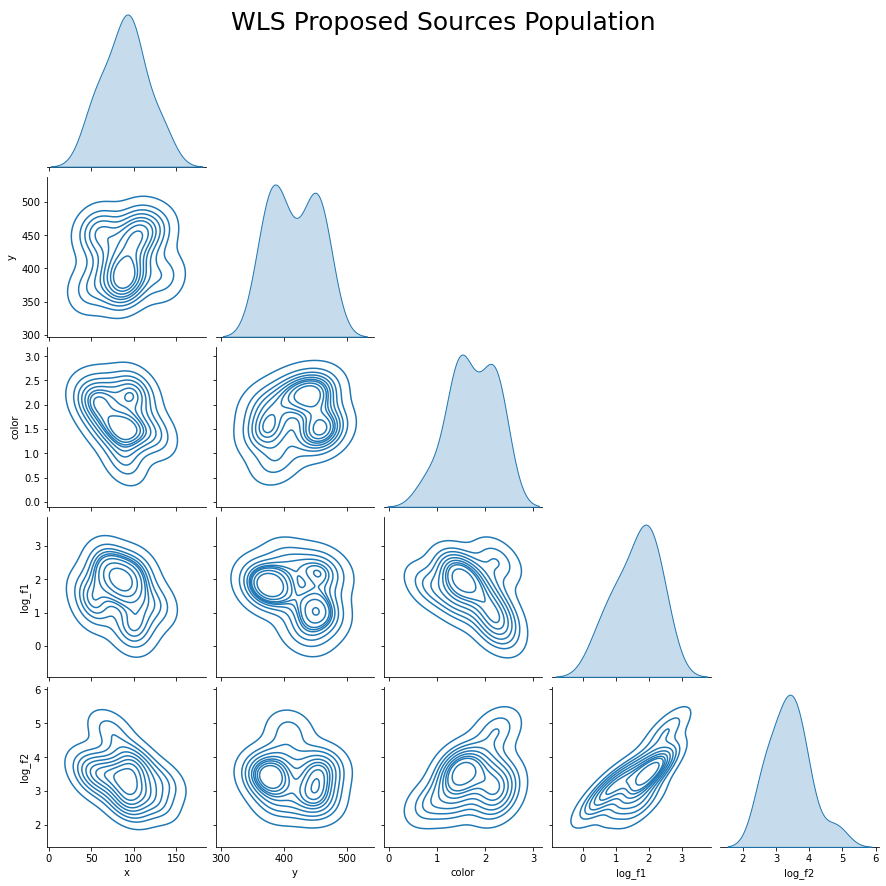

In [118]:
sns.pairplot(data=proposedSources, vars=['x', 'y', 'color', 'log_f1','log_f2'],kind='kde',corner=True)
plt.suptitle("WLS Proposed Sources Population",fontsize=25)
plt.show()

# MCMC 
for this section we want to use MCMC in order to sample from the posterior (which basically tells how likely the parameters we choose are true given the data)


In [16]:
import copy

In [17]:
def runMCMC(initialSources, initialImage, initialf2Image, backgroundFlux, truef1Image, truef2Image, trueCandidateNum,numSteps):
    #currentThetaState right now is the shape of beta so that's nFluxes +1 (for the background)
    #we want the currentThetaState to include the positions of the sources as well, should I do it so it's shape (3,nFluxes+1) where the columns are x, y, and flux?


    currentThetaStatePixels = np.array(initialSources)
    currentThetaStateImage = np.array(initialImage)
    currentThetaStatef2Image = np.array(initialf2Image)
    #currentThetaStateBackground = 2*backgroundFlux
    currentPosterior = np.nan
    #currentRandomProposedNoise = np.random.uniform(0, currentThetaStateBackground,size=10000).reshape(100,100)

    acceptedNum = 0
    rejectedNum = 0

    #kernel probability is just going to be uniform between 0 and 1
    stateCount = 0
    states = []
    stateProbs = []
    
    while(stateCount<=numSteps):
        proposedThetaStatePixels = copy.deepcopy(currentThetaStatePixels)
        proposedThetaStateImage = np.zeros((60, 60))
        proposedThetaStatef2Image = np.zeros((60, 60))
        #proposedThetaStateBackground = 0

        
        #only actually save every tenth state
        if(stateCount%10==0):
            print("saving!")
            states.append([currentThetaStatePixels])
        
        
        
        colorDistr = norm(2, 0.5)
        #i'm assuming a background which is sampled using a uniform distribution between 0 and background. 
        #proposedThetaStateBackground = max(0,np.random.normal(loc=currentThetaStateBackground,scale=1.0))
        #randomProposedNoise = np.random.uniform(0, proposedThetaStateBackground,size=10000)
        #randomProposedNoise = randomProposedNoise.reshape((100, 100))
        #proposedThetaStateImage += randomProposedNoise
        #proposedThetaStatef2Image += randomProposedNoise
        

        #note: the color prior calculated below technically aren't the true prior because when you multiply color prior of every pixel, even when using log, you get overflow problem and go to -inf
        #so instead we just take the average color prior over all the pixels
        for i in range(0,trueCandidateNum):

            totalCurrentLikelihood=0
            totalCurrentFluxPrior = 0
            totalCurrentColorPrior = 0
            
            totalProposedLikelihood = 0
            totalProposedFluxPrior = 0
            totalProposedColorPrior = 0

            proposedThetaStateImage = copy.deepcopy(currentThetaStateImage) 
            proposedThetaStatef2Image = copy.deepcopy(currentThetaStatef2Image) 

            for j in range(0,4):
                #propose a new source flux. if the proposed source flux is less than 0, then we should make it 0.
                proposedThetaStatePixels[j][i] = copy.deepcopy(max(0,np.random.normal(loc=currentThetaStatePixels[j][i],scale=0.1)))
            if(not np.isinf(flux_distribution._pdf(currentThetaStatePixels[2][i]))):
                totalCurrentFluxPrior+=np.log(flux_distribution._pdf(currentThetaStatePixels[2][i]))
                totalCurrentColorPrior+=np.log(colorDistr.pdf(currentThetaStatePixels[3][i]))
            if(proposedThetaStatePixels[3][i] > 21):
                 proposedThetaStatePixels[3][i] = 21
            #for the case where you have a source that has 0 flux we don't want the flux prior value to go to inf so we just don't include it because at that point
            #it simply just isn't a true source
            if(not np.isinf(flux_distribution._pdf(proposedThetaStatePixels[2][i]))):
                totalProposedFluxPrior+=np.log(flux_distribution._pdf(proposedThetaStatePixels[2][i]))
                totalProposedColorPrior+=np.log(colorDistr.pdf(proposedThetaStatePixels[3][i]))
            
            #get rid of the old source flux and add the new source flux
            proposedThetaStateImage -= gaussian_psf(currentThetaStatePixels[2][i],int(currentThetaStatePixels[0][i]), int(currentThetaStatePixels[1][i]), size=60, fwhm=2.5)
            proposedThetaStateImage += gaussian_psf(proposedThetaStatePixels[2][i],int(proposedThetaStatePixels[0][i]), int(proposedThetaStatePixels[1][i]), size=60, fwhm=2.5)
            proposedThetaStatef2Image -= gaussian_psf(np.exp(currentThetaStatePixels[3][i])*currentThetaStatePixels[2][i],int(currentThetaStatePixels[0][i]), int(currentThetaStatePixels[1][i]), size=60, fwhm=2.5)
            proposedThetaStatef2Image += gaussian_psf(np.exp(proposedThetaStatePixels[3][i])*proposedThetaStatePixels[2][i],int(proposedThetaStatePixels[0][i]), int(proposedThetaStatePixels[1][i]), size=60, fwhm=2.5)
        
    
            #note: the likelihoods calculated below technically aren't the true likelihood because of the long runtime. I decided to just take the likelihood from within 10 pixels of the source we're proposing
            for x in range(max(0,int(currentThetaStatePixels[0][i]-10)),min(60,int(currentThetaStatePixels[0][i]+10))):
                for y in range(max(0,int(currentThetaStatePixels[1][i]-10)),min(60,int(currentThetaStatePixels[1][i]+10))):
                        knownFlux1 = truef1Image[x, y]
                        knownFlux2 = truef2Image[x,y]
                        varFlux1 = knownFlux1
                        varFlux2 = knownFlux2
                        #if you have some fractional flux I'm going to say that the variance is 1 because if I don't then you get -inf a ton
                        if(knownFlux1<5):
                            varFlux1 = 5
                        if(knownFlux2<5):
                            varFlux2 = 5
                        
                        totalCurrentLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux1))+(-0.5*(knownFlux1-currentThetaStateImage[x, y])**2/varFlux1)
                        totalCurrentLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux2))+(-0.5*(knownFlux2-currentThetaStatef2Image[x, y])**2/varFlux2)
                        totalProposedLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux1))+(-0.5*(knownFlux1-proposedThetaStateImage[x, y])**2/varFlux1)
                        totalProposedLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux2))+(-0.5*(knownFlux2-proposedThetaStatef2Image[x, y])**2/varFlux2)

                #assuming that the marginal probability is just 1 (aka negligible)
            currentPosterior = (totalCurrentFluxPrior+totalCurrentColorPrior+totalCurrentLikelihood)
                
            proposedPosterior = (totalProposedFluxPrior+totalProposedColorPrior+totalProposedLikelihood)
                

            acceptanceProb = np.random.uniform(0,1)
            transitionProb = np.min([1,np.exp(proposedPosterior-currentPosterior)])
            
            if(np.isnan(currentPosterior) or np.isinf(currentPosterior) or currentPosterior==0):
                    print("ERROR")
                    print("currentFluxPrior: ",totalCurrentFluxPrior)
                    print("currentColorPrior: ",totalCurrentColorPrior)
                    print("currentLikelihood: ",totalCurrentLikelihood)
                    print(transitionProb>=acceptanceProb)
                    print(currentThetaStatePixels[3][i])
            if(np.isnan(proposedPosterior) or np.isinf(proposedPosterior) or proposedPosterior==0):
                    print("proposedFluxPrior: ",totalProposedFluxPrior)
                    print("proposedColorPrior: ",totalProposedColorPrior)
                    print("proposedLikelihood: ",totalProposedLikelihood)
                    transitionProb = 0
                    print(proposedThetaStatePixels[3][i])
                
            if(transitionProb>=acceptanceProb):
                    #print("accepted with probability ",acceptanceProb)
                    acceptedNum += 1
                    currentThetaStatePixels = copy.deepcopy(proposedThetaStatePixels)
                    #currentThetaStateBackground = proposedThetaStateBackground
                    currentPosterior = proposedPosterior
                    currentThetaStateImage = copy.deepcopy(proposedThetaStateImage)
                    currentThetaStatef2Image = copy.deepcopy(proposedThetaStatef2Image)
                    #currentRandomProposedNoise = copy.deepcopy(randomProposedNoise)
            else:
                    #print("rejected with probability ",acceptanceProb," and transition probability ",transitionProb)
                    #print(proposedPosterior-currentPosterior)
                    #print("rejected for source ",i,currentThetaStatePixels[3][i])
                    rejectedNum += 1
                    
                

        stateProbs.append([currentPosterior,totalCurrentLikelihood,totalCurrentFluxPrior,totalCurrentColorPrior])
        stateCount += 1
        print("State Count: ", stateCount, " Accepted: ", acceptedNum, " Rejected: ", rejectedNum," Acceptance Ratio: ", acceptedNum/(acceptedNum+rejectedNum))
    return (states,stateProbs)

## True initial positions and random initial flux/color pulled from the priors

In [19]:
initialSources = df[['x','y','adjusted_x','adjusted_y']]
initialSources['f1']=flux_distribution._rvs(size=len(initialSources))
initialSources['color']=np.random.normal(loc=2,scale=0.5,size=len(initialSources))
initialSources['f2']=initialSources['f1']*np.exp(initialSources['color'])

initialImage = np.zeros((60, 60))
initialf2Image = np.zeros((60, 60))

for index, row in initialSources.iterrows():
    initialImage[int(row['adjusted_x']),int(row['adjusted_y'])] = np.random.poisson(max(0,row['f1']), size=1)
    initialf2Image[int(row['adjusted_x']),int(row['adjusted_y'])] = np.random.poisson(max(0,row['f2']), size=1)
    initialImage += gaussian_psf(initialImage[int(row['adjusted_x']),int(row['adjusted_y'])],int(row['adjusted_x']), int(row['adjusted_y']), size=60, fwhm=2.5)
    initialf2Image += gaussian_psf(initialf2Image[int(row['adjusted_x']),int(row['adjusted_y'])],int(row['adjusted_x']), int(row['adjusted_y']), size=60, fwhm=2.5)

#assume we have no prior for the backgroundFlux so we just set it to have an average of 5 (which makes the max value 10)
randomNoise = np.random.uniform(0, 10,size=60*60)
randomNoise = randomNoise.reshape((60, 60))

initialImage += randomNoise
initialf2Image += randomNoise

initialSources = initialSources[['adjusted_x','adjusted_y','f1','color']]
initialSources = np.array(initialSources).T

withTruePositionStates,withTruePositionsProbs = runMCMC(initialSources,initialImage,initialf2Image,5,subf1Image,subf2Image,initialSources.shape[1],30000)

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

saving!
State Count:  1  Accepted:  2  Rejected:  6  Acceptance Ratio:  0.25
State Count:  2  Accepted:  3  Rejected:  13  Acceptance Ratio:  0.1875
State Count:  3  Accepted:  6  Rejected:  18  Acceptance Ratio:  0.25
State Count:  4  Accepted:  8  Rejected:  24  Acceptance Ratio:  0.25
State Count:  5  Accepted:  11  Rejected:  29  Acceptance Ratio:  0.275
State Count:  6  Accepted:  11  Rejected:  37  Acceptance Ratio:  0.22916666666666666
State Count:  7  Accepted:  14  Rejected:  42  Acceptance Ratio:  0.25
State Count:  8  Accepted:  20  Rejected:  44  Acceptance Ratio:  0.3125
State Count:  9  Accepted:  22  Rejected:  50  Acceptance Ratio:  0.3055555555555556
State Count:  10  Accepted:  24  Rejected:  56  Acceptance Ratio:  0.3
saving!
State Count:  11  Accepted:  28  Rejected:  60  Acceptance Ratio:  0.3181818181818182
State Count:  12  Accepted:  32  Rejected:  64  Acceptance Ratio:  0.3333333333333333
State Count:  13  Accepted:  33  Rejected:  71  Acceptance Ratio:  0.3173

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


State Count:  60  Accepted:  216  Rejected:  264  Acceptance Ratio:  0.45
saving!
State Count:  61  Accepted:  221  Rejected:  267  Acceptance Ratio:  0.45286885245901637
State Count:  62  Accepted:  226  Rejected:  270  Acceptance Ratio:  0.45564516129032256
State Count:  63  Accepted:  232  Rejected:  272  Acceptance Ratio:  0.4603174603174603
State Count:  64  Accepted:  235  Rejected:  277  Acceptance Ratio:  0.458984375
State Count:  65  Accepted:  242  Rejected:  278  Acceptance Ratio:  0.4653846153846154
State Count:  66  Accepted:  245  Rejected:  283  Acceptance Ratio:  0.4640151515151515
State Count:  67  Accepted:  250  Rejected:  286  Acceptance Ratio:  0.4664179104477612
State Count:  68  Accepted:  254  Rejected:  290  Acceptance Ratio:  0.46691176470588236
State Count:  69  Accepted:  258  Rejected:  294  Acceptance Ratio:  0.4673913043478261
State Count:  70  Accepted:  263  Rejected:  297  Acceptance Ratio:  0.46964285714285714
saving!
State Count:  71  Accepted:  268 

In [26]:
stateValues = np.array(withTruePositionStates)[:,0]
stateValues = np.array(stateValues.reshape(3001,4,8))


truePositionDF = pd.DataFrame(columns=['x','y','f1','color','f2','state','pointSource'])


for i in range(0,np.array(withTruePositionStates).shape[0]):
    truePositionDF = pd.concat([truePositionDF, pd.DataFrame(stateValues[i].T, columns=['x','y','f1','color'])], ignore_index=True)
    #truePositionDF['background'].iloc[i*initialSources.shape[1]:(i+1)*initialSources.shape[1]] = stateBackgrounds[i]
    truePositionDF['state'].iloc[i*initialSources.shape[1]:(i+1)*initialSources.shape[1]] = int(i)
    truePositionDF['f2'] = truePositionDF['f1'] * np.exp(truePositionDF['color'])
    for j in range(0,initialSources.shape[1]):
        truePositionDF['pointSource'].iloc[i*initialSources.shape[1]+j]=j
truePositionDF.to_csv('truePositionDF.csv', index=False)
truePositionDF

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


x          y         f1      color            f2 state  \
0      48.000000  43.000000   2.271042   1.895499  1.511576e+01     0   
1      10.000000  52.000000   2.590706   2.483155  3.103407e+01     0   
2      19.000000  46.000000   2.033625   2.422275  2.292194e+01     0   
3      12.000000   2.000000   1.402223   1.985945  1.021649e+01     0   
4      36.000000  42.000000   4.080769   2.826863  6.893391e+01     0   
...          ...        ...        ...        ...           ...   ...   
24003   8.486224  13.350451   6.294021  16.876400  1.343556e+08  3000   
24004  27.178782  20.594396  15.379388   6.419535  9.438606e+03  3000   
24005  46.250894  15.717224   1.685002   4.921065  2.310957e+02  3000   
24006  58.325960  13.461415   4.505184  20.160593  2.566533e+09  3000   
24007  55.639428  11.979598   1.824149   2.698295  2.709661e+01  3000   

      pointSource  
0               0  
1               1  
2               2  
3               3  
4               4  
...           ...  
24003           3  
24004           4  
24005           5  
24006           6  
24007           7  

[24008 rows x 7 columns]

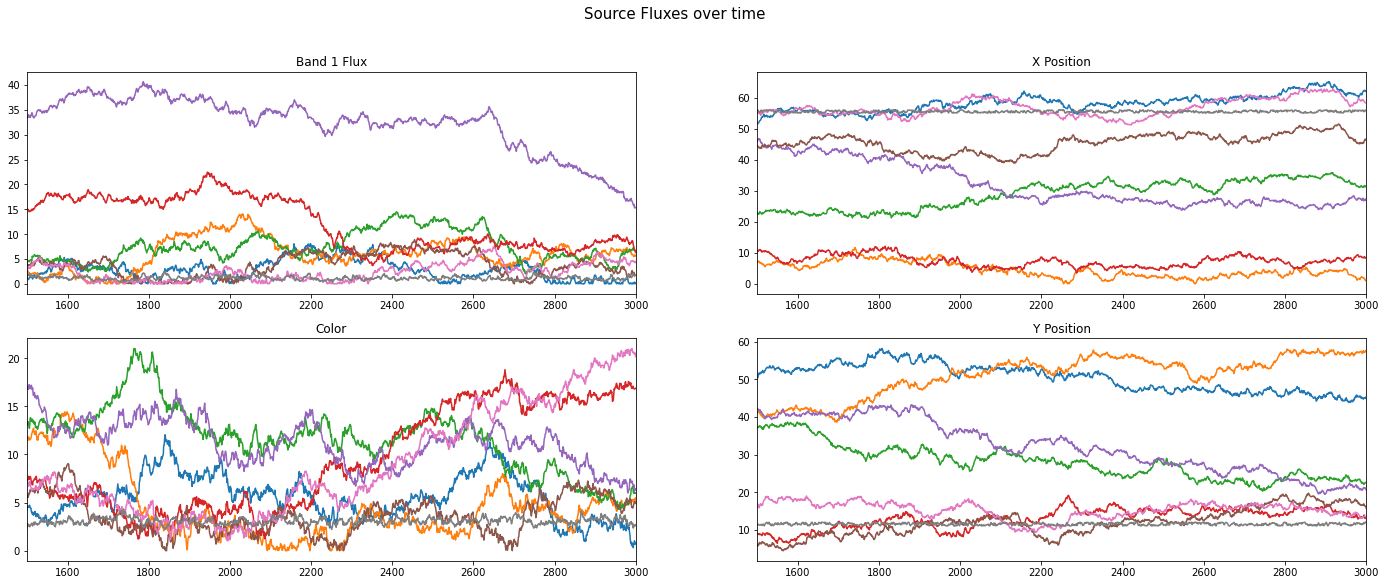

In [40]:
fig, axs = plt.subplots(2,2,figsize=(24, 9))
finalizedDF = pd.DataFrame(columns=['x','y','f1','color','f2','state','pointSource'])
truePositionDF = truePositionDF[truePositionDF['state'] >= 1500]
for source in truePositionDF.pointSource.unique():
    sourceNum = truePositionDF[truePositionDF['pointSource'] == source]
    sourceMedianf1 = sourceNum['f1'].median()
    sourceMedianf2 = sourceNum['f2'].median()
    sourceMedianColor = sourceNum['color'].median()
    sourceMedianX = sourceNum['x'].median()
    sourceMedianY = sourceNum['y'].median()
    finalizedDF = pd.concat([finalizedDF, pd.DataFrame({'x': [sourceMedianX], 'y': [sourceMedianY], 'f1': [sourceMedianf1], 'color': [sourceMedianColor], 'f2': [sourceMedianf2], 'state': ['median'], 'pointSource': [source]})], ignore_index=True)
    axs[0,0].plot(sourceNum['state'],sourceNum['f1'],label='Source '+str(source))
    axs[1,0].plot(sourceNum['state'],sourceNum['color'],label='Source '+str(source))
    axs[0,1].plot(sourceNum['state'],sourceNum['x'])
    axs[1,1].plot(sourceNum['state'],sourceNum['y'])
plt.suptitle("Source Fluxes over time",fontsize=15)
axs[0,0].set_title('Band 1 Flux')
axs[1,0].set_title('Color')
axs[0,1].set_title('X Position')
axs[1,1].set_title('Y Position')
axs[0,0].set_xlim((1500,3000))
axs[0,1].set_xlim((1500,3000))
axs[1,0].set_xlim((1500,3000))
axs[1,1].set_xlim((1500,3000))

plt.show()

In [41]:
df

x    y     color        f1    log_f1          f2    log_f2  \
19   84  410  1.400503  1.646813  0.498842    6.681516  1.899345   
42   46  419  1.312972  1.325778  0.281999    4.928188  1.594971   
118  55  413  1.156184  1.740804  0.554347    5.531901  1.710531   
134  48  369  3.066131  1.123192  0.116175   24.102257  3.182305   
393  72  409  2.831829  5.974624  1.787521  101.428066  4.619350   
458  84  370  1.726746  4.103351  1.411804   23.070397  3.138550   
480  89  388  1.570163  2.473876  0.905786   11.892988  2.475949   
482  91  378  2.106968  3.181281  1.157284   26.160534  3.264252   

    in_subsection  adjusted_x  adjusted_y  
19           True          48          43  
42           True          10          52  
118          True          19          46  
134          True          12           2  
393          True          36          42  
458          True          48           3  
480          True          53          21  
482          True          55          11

In [ ]:
finalizedDF['x'] = finalizedDF['x'].astype(int)
finalizedDF['y'] = finalizedDF['y'].astype(int)
finalizedDF

x   y         f1      color            f2   state pointSource
0  58  51   2.744046   5.539758  6.271504e+02  median           0
1   4  52   5.958545   3.422639  2.139313e+02  median           1
2  30  27   6.970583  12.129357  1.328706e+06  median           2
3   7  13  10.005161   8.125468  2.484838e+04  median           3
4  28  31  33.409239  11.467658  3.064115e+06  median           4
5  46  11   3.833103   3.382829  1.123287e+02  median           5
6  56  15   2.318292   6.828970  2.232441e+03  median           6
7  55  11   1.107738   3.064336  2.443395e+01  median           7

In [ ]:
pairings = [finalizedDF[finalizedDF['pointSource']==7],df[df['adjusted_x']==55]]
pairings.append([finalizedDF[finalizedDF['pointSource']==6],df[df['adjusted_x']==56]])

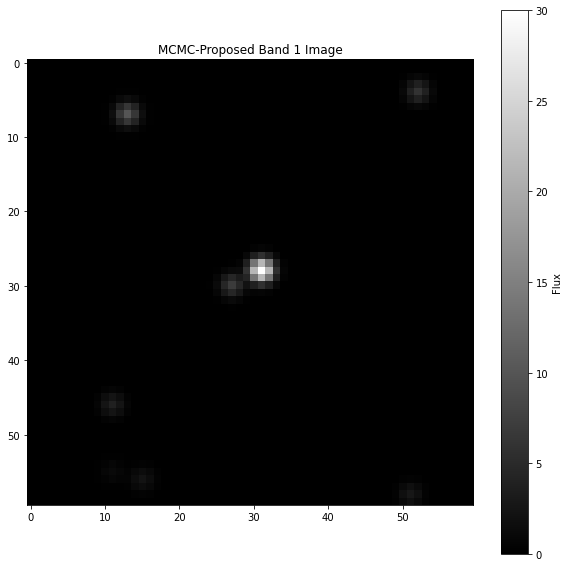

In [52]:
fig,ax = plt.subplots(figsize=(10, 10))


xx, yy = np.meshgrid(x, y,indexing='ij')
MCMCimage = np.zeros((60, 60))


for index, row in finalizedDF.iterrows():
    MCMCimage += gaussian_psf(row['f1'],int(row['x']), int(row['y']), size=60, fwhm=2.5)


plt.imshow(MCMCimage, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("MCMC-Proposed Band 1 Image")
plt.show()

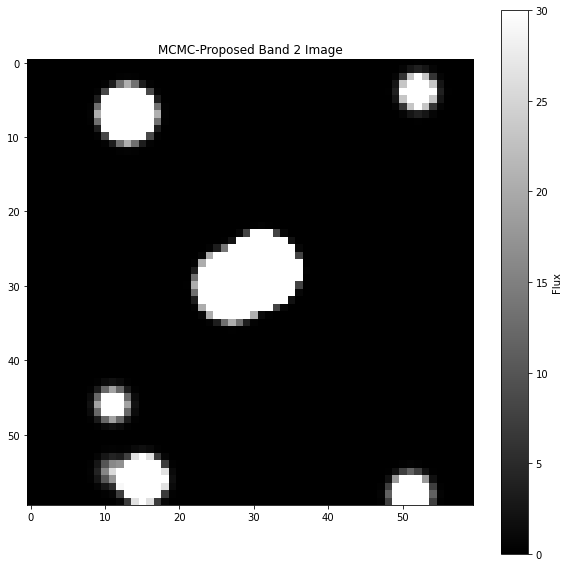

In [53]:
fig,ax = plt.subplots(figsize=(10, 10))


xx, yy = np.meshgrid(x, y,indexing='ij')
MCMCimage = np.zeros((60, 60))


for index, row in finalizedDF.iterrows():
    MCMCimage += gaussian_psf(row['f2'],int(row['x']), int(row['y']), size=60, fwhm=2.5)


plt.imshow(MCMCimage, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("MCMC-Proposed Band 2 Image")
plt.show()

## Use Inferred Positions and Fluxes Initially

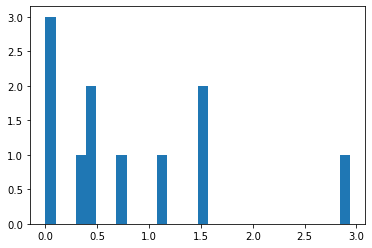

In [ ]:
proposedSources['adjusted_x'] = proposedSources['x'] - startX
proposedSources['adjusted_y'] = proposedSources['y'] - startY

In [ ]:
initialSources = proposedSources[['x','y','adjusted_x','adjusted_y','f1','color']]
initialImage = np.zeros((100, 100))
initialf2Image = np.zeros((100, 100))

for index, row in proposedSources.iterrows():
    initialImage[int(row['adjusted_x']),int(row['adjusted_y'])] = np.random.poisson(max(0,row['f1']), size=1)
    initialf2Image[int(row['adjusted_x']),int(row['adjusted_y'])] = np.random.poisson(max(0,row['f2']), size=1)
    initialImage += gaussian_psf(initialImage[int(row['adjusted_x']),int(row['adjusted_y'])],int(row['adjusted_x']), int(row['adjusted_y']), size=100, fwhm=2.5)
    initialf2Image += gaussian_psf(initialf2Image[int(row['adjusted_x']),int(row['adjusted_y'])],int(row['adjusted_x']), int(row['adjusted_y']), size=100, fwhm=2.5)

#the background flux we found with wsl is really the average background flux which for a uniform distribution assumes that the max value should be 2* that
randomNoise = np.random.uniform(0, 2*backgroundFlux,size=10000)
randomNoise = randomNoise.reshape((100, 100))

initialImage += randomNoise
initialf2Image += randomNoise

initialSources = initialSources[['adjusted_x','adjusted_y','f1','color']]
initialSources = np.array(initialSources).T


states = runMCMC(initialSources,initialImage,initialf2Image,backgroundFlux,subf1Image,subf2Image,len(proposedSources),30000)

## Use true positions but offset by 1 pixel

In [ ]:
offsetDF = df
for index, row in df.iterrows():
    prob = np.random.rand(0, 1)
    if(prob>0.5):
        offsetDF.loc[index, 'adjusted_x'] += 1
        offsetDF.loc[index, 'adjusted_y'] += 1
        offsetDF.loc[index, 'x'] += 1
        offsetDF.loc[index, 'y'] += 1
    else:
        offsetDF.loc[index, 'adjusted_x'] -= 1
        offsetDF.loc[index, 'adjusted_y'] -= 1
        offsetDF.loc[index, 'x'] -= 1
        offsetDF.loc[index, 'y'] -= 1


initialSources = offsetDF[['x','y','adjusted_x','adjusted_y']]
initialSources['f1']=flux_distribution._rvs(size=len(initialSources))
initialSources['color']=np.random.normal(loc=2,scale=0.5,size=len(initialSources))
initialSources['f2']=initialSources['f1']*np.exp(initialSources['color'])

initialImage = np.zeros((100, 100))
initialf2Image = np.zeros((100, 100))

for index, row in initialSources.iterrows():
    initialImage[int(row['adjusted_x']),int(row['adjusted_y'])] = np.random.poisson(max(0,row['f1']), size=1)
    initialf2Image[int(row['adjusted_x']),int(row['adjusted_y'])] = np.random.poisson(max(0,row['f2']), size=1)
    initialImage += gaussian_psf(initialImage[int(row['adjusted_x']),int(row['adjusted_y'])],int(row['adjusted_x']), int(row['adjusted_y']), size=100, fwhm=2.5)
    initialf2Image += gaussian_psf(initialf2Image[int(row['adjusted_x']),int(row['adjusted_y'])],int(row['adjusted_x']), int(row['adjusted_y']), size=100, fwhm=2.5)

#assume we have no prior for the backgroundFlux so we just set it to have an average of 5 (which makes the max value 10)
randomNoise = np.random.uniform(0, 10,size=10000)
randomNoise = randomNoise.reshape((100, 100))

initialImage += randomNoise
initialf2Image += randomNoise

initialSources = initialSources[['adjusted_x','adjusted_y','f1','color']]
initialSources = np.array(initialSources).T

withTruePositionStates,withTruePositionsProbs = runMCMC(initialSources,initialImage,initialf2Image,5,subf1Image,subf2Image,initialSources.shape[1],30000)

## With Incorrect Flux Prior

In [ ]:
def runWrongMCMC(initialSources, initialImage, initialf2Image, backgroundFlux, truef1Image, truef2Image, trueCandidateNum,numSteps):
    #currentThetaState right now is the shape of beta so that's nFluxes +1 (for the background)
    #we want the currentThetaState to include the positions of the sources as well, should I do it so it's shape (3,nFluxes+1) where the columns are x, y, and flux?


    currentThetaStatePixels = np.array(initialSources)
    currentThetaStateImage = np.array(initialImage)
    currentThetaStatef2Image = np.array(initialf2Image)
    #currentThetaStateBackground = 2*backgroundFlux
    currentPosterior = np.nan
    #currentRandomProposedNoise = np.random.uniform(0, currentThetaStateBackground,size=10000).reshape(100,100)

    acceptedNum = 0
    rejectedNum = 0

    #kernel probability is just going to be uniform between 0 and 1
    stateCount = 0
    states = []
    stateProbs = []
    
    while(stateCount<=numSteps):
        proposedThetaStatePixels = copy.deepcopy(currentThetaStatePixels)
        proposedThetaStateImage = np.zeros((100, 100))
        proposedThetaStatef2Image = np.zeros((100, 100))
        #proposedThetaStateBackground = 0

        
        #only actually save every tenth state
        if(stateCount%10==0):
            print("saving!")
            states.append([currentThetaStatePixels])
        
        
        
        colorDistr = norm(2, 0.5)
        #i'm assuming a background which is sampled using a uniform distribution between 0 and background. 
        #proposedThetaStateBackground = max(0,np.random.normal(loc=currentThetaStateBackground,scale=1.0))
        #randomProposedNoise = np.random.uniform(0, proposedThetaStateBackground,size=10000)
        #randomProposedNoise = randomProposedNoise.reshape((100, 100))
        #proposedThetaStateImage += randomProposedNoise
        #proposedThetaStatef2Image += randomProposedNoise
        

        #note: the color prior calculated below technically aren't the true prior because when you multiply color prior of every pixel, even when using log, you get overflow problem and go to -inf
        #so instead we just take the average color prior over all the pixels
        for i in range(0,trueCandidateNum):

            totalCurrentLikelihood=0
            totalCurrentFluxPrior = 0
            totalCurrentColorPrior = 0
            
            totalProposedLikelihood = 0
            totalProposedFluxPrior = 0
            totalProposedColorPrior = 0

            proposedThetaStateImage = copy.deepcopy(currentThetaStateImage) 
            proposedThetaStatef2Image = copy.deepcopy(currentThetaStatef2Image) 

            for j in range(0,4):
                #propose a new source flux. if the proposed source flux is less than 0, then we should make it 0.
                proposedThetaStatePixels[j][i] = copy.deepcopy(max(0,np.random.normal(loc=currentThetaStatePixels[j][i],scale=0.1)))
            if(not np.isinf(flux_distribution._pdf(currentThetaStatePixels[2][i]))):
                totalCurrentFluxPrior+=np.log(flux_distribution._wrongpdf(currentThetaStatePixels[2][i]))
                totalCurrentColorPrior+=np.log(colorDistr.pdf(currentThetaStatePixels[3][i]))
            #for the case where you have a source that has 0 flux we don't want the flux prior value to go to inf so we just don't include it because at that point
            #it simply just isn't a true source
            if(not np.isinf(flux_distribution._pdf(proposedThetaStatePixels[2][i]))):
                totalProposedFluxPrior+=np.log(flux_distribution._wrongpdf(proposedThetaStatePixels[2][i]))
                totalProposedColorPrior+=np.log(colorDistr.pdf(proposedThetaStatePixels[3][i]))
            
            #get rid of the old source flux and add the new source flux
            proposedThetaStateImage -= gaussian_psf(currentThetaStatePixels[2][i],int(currentThetaStatePixels[0][i]), int(currentThetaStatePixels[1][i]), size=100, fwhm=2.5)
            proposedThetaStateImage += gaussian_psf(proposedThetaStatePixels[2][i],int(proposedThetaStatePixels[0][i]), int(proposedThetaStatePixels[1][i]), size=100, fwhm=2.5)
            proposedThetaStatef2Image -= gaussian_psf(np.exp(currentThetaStatePixels[3][i])*currentThetaStatePixels[2][i],int(currentThetaStatePixels[0][i]), int(currentThetaStatePixels[1][i]), size=100, fwhm=2.5)
            proposedThetaStatef2Image += gaussian_psf(np.exp(proposedThetaStatePixels[3][i])*proposedThetaStatePixels[2][i],int(proposedThetaStatePixels[0][i]), int(proposedThetaStatePixels[1][i]), size=100, fwhm=2.5)
        
    
            #note: the likelihoods calculated below technically aren't the true likelihood because of the long runtime. I decided to just take the likelihood from within 10 pixels of the source we're proposing
            for x in range(max(0,int(currentThetaStatePixels[0][i]-10)),min(100,int(currentThetaStatePixels[0][i]+10))):
                for y in range(max(0,int(currentThetaStatePixels[1][i]-10)),min(100,int(currentThetaStatePixels[1][i]+10))):
                        knownFlux1 = truef1Image[x, y]
                        knownFlux2 = truef2Image[x,y]
                        varFlux1 = knownFlux1
                        varFlux2 = knownFlux2
                        #if you have some fractional flux I'm going to say that the variance is 1 because if I don't then you get -inf a ton
                        if(knownFlux1<5):
                            varFlux1 = 5
                        if(knownFlux2<5):
                            varFlux2 = 5
                        
                        totalCurrentLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux1))+(-0.5*(knownFlux1-currentThetaStateImage[x, y])**2/varFlux1)
                        totalCurrentLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux2))+(-0.5*(knownFlux2-currentThetaStatef2Image[x, y])**2/varFlux2)
                        totalProposedLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux1))+(-0.5*(knownFlux1-proposedThetaStateImage[x, y])**2/varFlux1)
                        totalProposedLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux2))+(-0.5*(knownFlux2-proposedThetaStatef2Image[x, y])**2/varFlux2)

                #assuming that the marginal probability is just 1 (aka negligible)
            currentPosterior = (totalCurrentFluxPrior+totalCurrentColorPrior+totalCurrentLikelihood)
                
            proposedPosterior = (totalProposedFluxPrior+totalProposedColorPrior+totalProposedLikelihood)
                

            acceptanceProb = np.random.uniform(0,1)
            transitionProb = np.min([1,np.exp(proposedPosterior-currentPosterior)])
            
            if(np.isnan(currentPosterior) or np.isinf(currentPosterior) or currentPosterior==0):
                    print("ERROR")
                    print("currentFluxPrior: ",totalCurrentFluxPrior)
                    print("currentColorPrior: ",totalCurrentColorPrior)
                    print("currentLikelihood: ",totalCurrentLikelihood)
                    print(transitionProb>=acceptanceProb)
                    print(currentThetaStatePixels[3][i])
            if(np.isnan(proposedPosterior) or np.isinf(proposedPosterior) or proposedPosterior==0):
                    print("proposedFluxPrior: ",totalProposedFluxPrior)
                    print("proposedColorPrior: ",totalProposedColorPrior)
                    print("proposedLikelihood: ",totalProposedLikelihood)
                    transitionProb = 0
                    print(proposedThetaStatePixels[3][i])
                
            if(transitionProb>=acceptanceProb):
                    #print("accepted with probability ",acceptanceProb)
                    acceptedNum += 1
                    currentThetaStatePixels = copy.deepcopy(proposedThetaStatePixels)
                    #currentThetaStateBackground = proposedThetaStateBackground
                    currentPosterior = proposedPosterior
                    currentThetaStateImage = copy.deepcopy(proposedThetaStateImage)
                    currentThetaStatef2Image = copy.deepcopy(proposedThetaStatef2Image)
                    #currentRandomProposedNoise = copy.deepcopy(randomProposedNoise)
            else:
                    #print("rejected with probability ",acceptanceProb," and transition probability ",transitionProb)
                    #print(proposedPosterior-currentPosterior)
                    #print("rejected for source ",i,currentThetaStatePixels[3][i])
                    rejectedNum += 1
                    
                

        stateProbs.append([currentPosterior,totalCurrentLikelihood,totalCurrentFluxPrior,totalCurrentColorPrior])
        stateCount += 1
        print("State Count: ", stateCount, " Accepted: ", acceptedNum, " Rejected: ", rejectedNum," Acceptance Ratio: ", acceptedNum/(acceptedNum+rejectedNum))
    return (states,stateProbs)

In [ ]:
initialSources = df[['x','y','adjusted_x','adjusted_y']]
initialSources['f1']=flux_distribution._wrongrvs(size=len(initialSources))
initialSources['color']=np.random.normal(loc=2,scale=0.5,size=len(initialSources))
initialSources['f2']=initialSources['f1']*np.exp(initialSources['color'])

initialImage = np.zeros((100, 100))
initialf2Image = np.zeros((100, 100))

for index, row in initialSources.iterrows():
    initialImage[int(row['adjusted_x']),int(row['adjusted_y'])] = np.random.poisson(max(0,row['f1']), size=1)
    initialf2Image[int(row['adjusted_x']),int(row['adjusted_y'])] = np.random.poisson(max(0,row['f2']), size=1)
    initialImage += gaussian_psf(initialImage[int(row['adjusted_x']),int(row['adjusted_y'])],int(row['adjusted_x']), int(row['adjusted_y']), size=100, fwhm=2.5)
    initialf2Image += gaussian_psf(initialf2Image[int(row['adjusted_x']),int(row['adjusted_y'])],int(row['adjusted_x']), int(row['adjusted_y']), size=100, fwhm=2.5)

#assume we have no prior for the backgroundFlux so we just set it to have an average of 5 (which makes the max value 10)
randomNoise = np.random.uniform(0, 10,size=10000)
randomNoise = randomNoise.reshape((100, 100))

initialImage += randomNoise
initialf2Image += randomNoise

initialSources = initialSources[['adjusted_x','adjusted_y','f1','color']]
initialSources = np.array(initialSources).T

withTruePositionStates,withTruePositionsProbs = runWrongMCMC(initialSources,initialImage,initialf2Image,5,subf1Image,subf2Image,initialSources.shape[1],30000)